# Praca domowa

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/dataset/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/food41

mkdir: cannot create directory ‘/root/.kaggle’: File exists
food41.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# ! cp food41.zip /content/drive/MyDrive/dataset/food41.zip

Wybiorę kilka włoskich dań ze zbioru danych

In [5]:
# %%capture
# ! rm -R images_out

In [6]:
! mkdir images_out

In [7]:
%%capture
! mkdir images_out/spaghetti_carbonara
! unzip -j food41.zip "images/spaghetti_carbonara/*" -d "images_out/spaghetti_carbonara" 

In [8]:
%%capture
! mkdir images_out/cannoli
! unzip -j food41.zip "images/cannoli/*" -d "images_out/cannoli" 

In [9]:
%%capture
! mkdir images_out/spaghetti_bolognese
! unzip -j food41.zip "images/spaghetti_bolognese/*" -d "images_out/spaghetti_bolognese" 

In [10]:
%%capture
! mkdir images_out/gnocchi
! unzip -j food41.zip "images/gnocchi/*" -d "images_out/gnocchi" 

In [11]:
%%capture
! mkdir images_out/tiramisu
! unzip -j food41.zip "images/tiramisu/*" -d "images_out/tiramisu" 

In [12]:
%%capture
! mkdir images_out/lasagna
! unzip -j food41.zip "images/lasagna/*" -d "images_out/lasagna" 

In [13]:
%%capture
! mkdir images_out/pizza
! unzip -j food41.zip "images/pizza/*" -d "images_out/pizza" 

Praca z danymi

In [14]:
import torch
import torchvision

In [15]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor()
])

In [16]:
dataset = torchvision.datasets.ImageFolder('images_out',transform=transforms)

In [17]:
n = len(dataset)
n

7000

In [18]:
train_set, test_set = torch.utils.data.random_split(dataset, [6000, 1000])

In [31]:
import matplotlib.pyplot as plt

In [62]:
def find_image_by_index(set_load, ind):
    loader = torch.utils.data.DataLoader(set_load, shuffle=False, num_workers=2, batch_size=1)
    current = 0
    for batch in loader:     
        if current == ind:
            searched = batch
            break
        else:
            current += 1
    return searched[0][0,:,:,:], searched[1]


def show_img(dataset, mapping, idx):
    plt.axis("off")
    img, label = find_image_by_index(dataset, idx)
    plt.title(mapping[label.item()])
    plt.imshow(img.permute(1, 2, 0))
    plt.show()

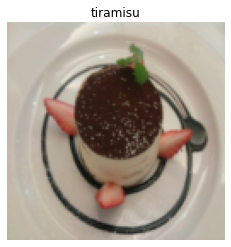

In [37]:
show_img(train_set, dataset.classes, 3)

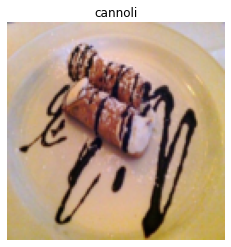

In [29]:
show_img(train_set, dataset.classes, 19)

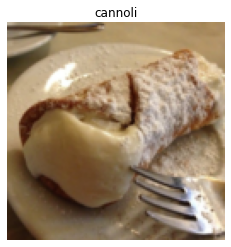

In [32]:
show_img(train_set, dataset.classes, 24)

## Trenowanie sieci

In [19]:
if torch.cuda.is_available():  
    DEVICE = "cuda:0" 
else:  
    DEVICE = "cpu"

In [20]:
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, num_workers=2, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=10)

Część kodu zaczerpnieta z: https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [21]:
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [30]:
res_net_18_1 = ResNet18()
res_net_18_1.linear = nn.Linear(8192, 7)
res_net_18_1 = res_net_18_1.to(DEVICE)

In [31]:
criterion_1 = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(res_net_18_1.parameters(), lr = 0.001)

In [ ]:
epochs = 10

In [ ]:
train_acc = []
test_acc = []

for epoch in range(epochs):
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        loss = criterion_1(preds, labels)

        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set)
    train_acc.append(accuracy_train)

    # test
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")

Epoch: 0, train accuracy: 0.29933333333333334, test accuracy: 0.383
Epoch: 1, train accuracy: 0.38, test accuracy: 0.408
Epoch: 2, train accuracy: 0.4201666666666667, test accuracy: 0.415
Epoch: 3, train accuracy: 0.4503333333333333, test accuracy: 0.443
Epoch: 4, train accuracy: 0.4795, test accuracy: 0.47
Epoch: 5, train accuracy: 0.5236666666666666, test accuracy: 0.5
Epoch: 6, train accuracy: 0.5495, test accuracy: 0.512
Epoch: 7, train accuracy: 0.595, test accuracy: 0.559
Epoch: 8, train accuracy: 0.6245, test accuracy: 0.578
Epoch: 9, train accuracy: 0.662, test accuracy: 0.587


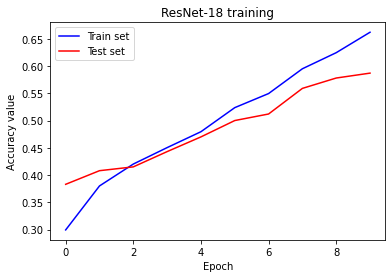

In [ ]:
import numpy as np

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [ ]:
torch.save(res_net_18_1.state_dict(), '/content/drive/MyDrive/dataset/res_net_18_1.model')

In [ ]:
import pickle

with open('/content/drive/MyDrive/dataset/train_acc_hist_1', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/dataset/test_acc_hist_1', 'wb') as f:
    pickle.dump(test_acc, f)

In [35]:
epochs = 3

In [36]:
for epoch in range(epochs):
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        loss = criterion_1(preds, labels)

        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set)
    train_acc.append(accuracy_train)

    # test
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch + 10}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")

Epoch: 10, train accuracy: 0.6805, test accuracy: 0.665
Epoch: 11, train accuracy: 0.7193333333333334, test accuracy: 0.68
Epoch: 12, train accuracy: 0.7515, test accuracy: 0.697


In [37]:
torch.save(res_net_18_1.state_dict(), '/content/drive/MyDrive/dataset/res_net_18_1_continued_1a.model')

In [38]:
import pickle

with open('/content/drive/MyDrive/dataset/train_acc_hist_1_continued_1a', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/dataset/test_acc_hist_1_continued_1a', 'wb') as f:
    pickle.dump(test_acc, f)

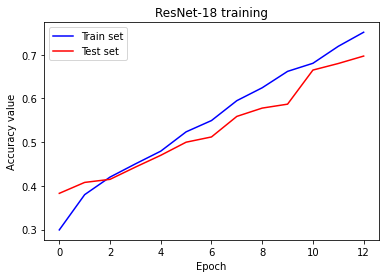

In [41]:
import numpy as np

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

In [42]:
for epoch in range(epochs):
    correct_train = 0
    for batch in train_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        loss = criterion_1(preds, labels)

        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        _, predicted = preds.max(1)

        correct_train += predicted.eq(labels).sum().item()

    accuracy_train = correct_train / len(train_set)
    train_acc.append(accuracy_train)

    # test
    correct_test = 0

    for batch in test_loader:     
        images = batch[0].to(DEVICE)
        labels = batch[1].to(DEVICE)
        preds = res_net_18_1(images)
        _, predicted = preds.max(1)
        correct_test += predicted.eq(labels).sum().item()

    accuracy_test = correct_test / len(test_set)
    test_acc.append(accuracy_test)

    print(f"Epoch: {epoch + 13}, train accuracy: {accuracy_train}, test accuracy: {accuracy_test}")

Epoch: 13, train accuracy: 0.7966666666666666, test accuracy: 0.669
Epoch: 14, train accuracy: 0.8293333333333334, test accuracy: 0.704
Epoch: 15, train accuracy: 0.8656666666666667, test accuracy: 0.696


In [43]:
torch.save(res_net_18_1.state_dict(), '/content/drive/MyDrive/dataset/res_net_18_1_continued_1b.model')

In [44]:
import pickle

with open('/content/drive/MyDrive/dataset/train_acc_hist_1_continued_1b', 'wb') as f:
    pickle.dump(train_acc, f)

with open('/content/drive/MyDrive/dataset/test_acc_hist_1_continued_1b', 'wb') as f:
    pickle.dump(test_acc, f)

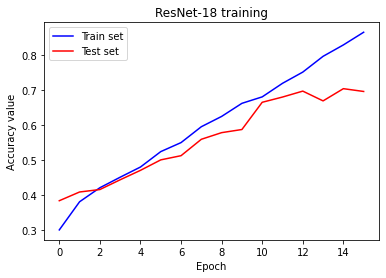

In [45]:
import numpy as np

plt.plot(np.arange(len(train_acc)), train_acc, color = 'blue')
plt.plot(np.arange(len(test_acc)), test_acc, color = 'red')
plt.legend(['Train set', 'Test set'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy value')
plt.title('ResNet-18 training')
plt.show()

Model zaczął się przeuczać, a zatem do kolejnych rozważań wezmę model stworzony po 13 epokach.

Wynik na zbiorze testowym na poziomie $0.7$ może nie wyglądać na zadowalający, jednak inni użytkownicy Kaggle'a trenując sieci ResNet na pełnym zbiorze (100 klas) uzyskiwali wyniki najwyższe na poziomie $0.6$.

Przykkładowo: https://www.kaggle.com/code/mrmaheshchavan/foodclassification-resnet-vs-efficientnet-10epochs

Ponadto, zdjęcia w zbiorze danych nie są najlepszej jakości, a zatem uzyskany wynik uważam za dobry.

In [97]:
# aby zostawić taki sam zbiór testowy na kolejne kroki

torch.save(test_set, '/content/drive/MyDrive/dataset/test_set')

In [22]:
model = ResNet18()
model.linear = nn.Linear(8192, 7)
model = model.to(DEVICE)

In [23]:
model.load_state_dict(torch.load('/content/drive/MyDrive/dataset/res_net_18_1_continued_1a.model'))

<All keys matched successfully>

### Macierz konfuzji

In [24]:
test_set = torch.load('/content/drive/MyDrive/dataset/test_set')

In [25]:
single_test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, num_workers=2, batch_size=1)

In [100]:
y_hat = []
y_test = []

for batch in single_test_loader:     
    images = batch[0].to(DEVICE)
    labels = batch[1].to(DEVICE)
    preds = model(images)
    _, predicted = preds.max(1)
    y_hat += predicted.tolist()
    y_test += labels.tolist()

<Figure size 864x864 with 0 Axes>

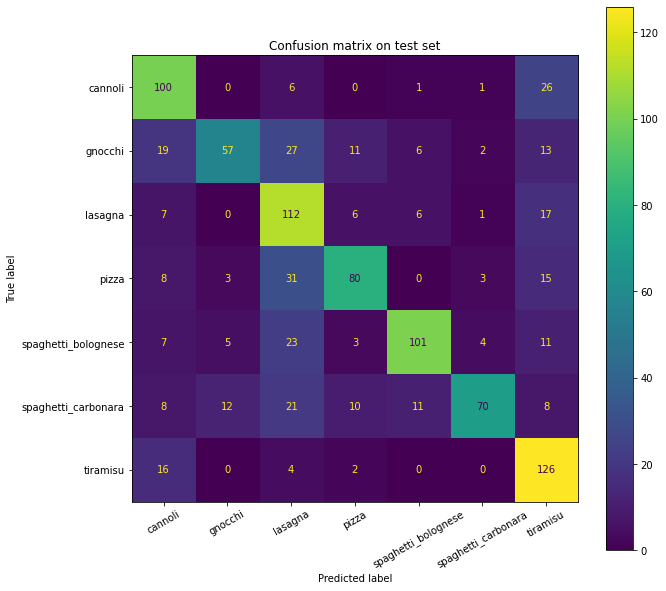

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
cm = confusion_matrix(y_test, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.title('Confusion matrix on test set')
plt.xticks(rotation=30)
plt.show()

In [114]:
y_hat_classes = [dataset.classes[i] for i in y_hat]
y_test_classes = [dataset.classes[i] for i in y_test]

In [112]:
def find_wrongs(class_hat, class_test):
    wrongs = []
    for i in range(len(y_hat_classes)):
        if y_hat_classes[i] == class_hat and y_test_classes[i] == class_test:
            wrongs.append(i)
    return wrongs

def find_image_by_index(set_, ind):
    loader = single_test_loader
    current = 0
    for batch in loader:     
        if current == ind:
            searched = batch
            break
        else:
            current += 1
    return searched[0][0,:,:,:]

def show_img2(idx, title):
    i = 0
    im = None
    for batch in single_test_loader:  
        if i == idx:
            im = batch[0][0]
            break
        i = i + 1

    plt.title(title)
    plt.axis("off")
    plt.imshow(im.permute(1, 2, 0))
    #plt.show()

In [94]:
tiramisu_cannoli = find_wrongs('tiramisu', 'cannoli')

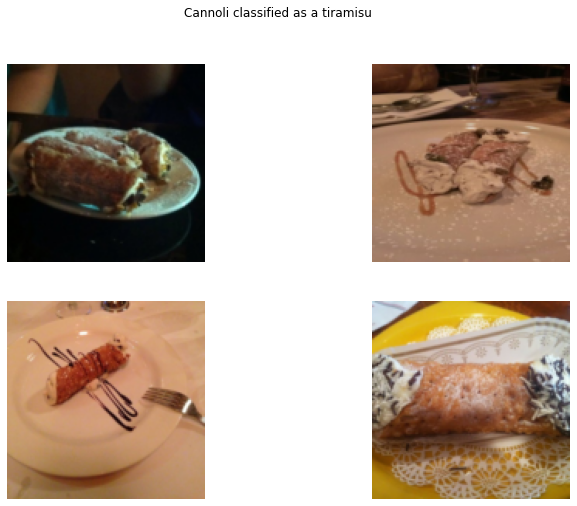

In [93]:
fig = plt.figure(figsize = (12, 8))
plt.suptitle('Cannoli classified as a tiramisu')

plt.subplot(2, 2, 1)
show_img2(tiramisu_cannoli[0], '')

plt.subplot(2, 2, 2)
show_img2(tiramisu_cannoli[1], '')

plt.subplot(2, 2, 3)
show_img2(tiramisu_cannoli[2], '')

plt.subplot(2, 2, 4)
show_img2(tiramisu_cannoli[5], '')

plt.show()

In [95]:
lasagna_pizza = find_wrongs('lasagna', 'pizza')

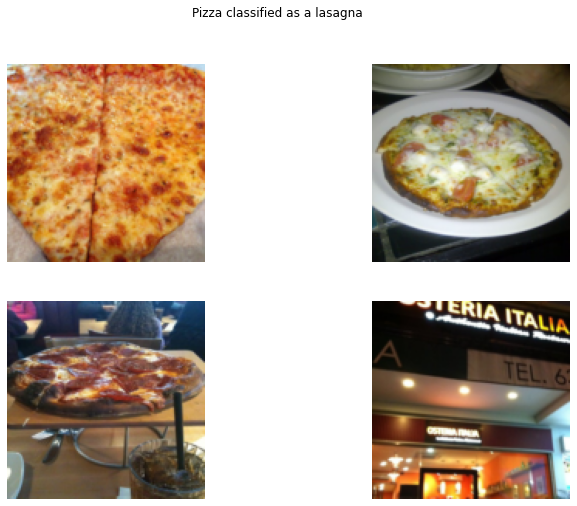

In [96]:
fig = plt.figure(figsize = (12, 8))
plt.suptitle('Pizza classified as a lasagna')

plt.subplot(2, 2, 1)
show_img2(lasagna_pizza[0], '')

plt.subplot(2, 2, 2)
show_img2(lasagna_pizza[1], '')

plt.subplot(2, 2, 3)
show_img2(lasagna_pizza[2], '')

plt.subplot(2, 2, 4)
show_img2(lasagna_pizza[5], '')

plt.show()

In [98]:
bolognese_pizza = find_wrongs('lasagna', 'spaghetti_bolognese')

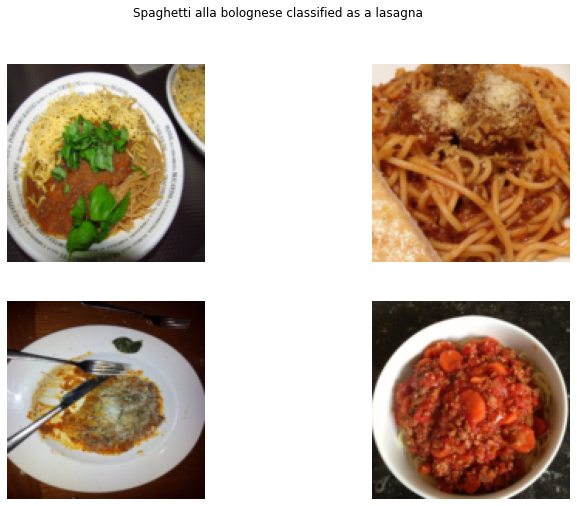

In [102]:
fig = plt.figure(figsize = (12, 8))
plt.suptitle('Spaghetti alla bolognese classified as a lasagna')

plt.subplot(2, 2, 1)
show_img2(bolognese_pizza[0], '')

plt.subplot(2, 2, 2)
show_img2(bolognese_pizza[1], '')

plt.subplot(2, 2, 3)
show_img2(bolognese_pizza[2], '')

plt.subplot(2, 2, 4)
show_img2(bolognese_pizza[5], '')

plt.show()

### Wyjaśnienia

In [30]:
! pip install captum

     |████████████████████████████████| 1.4 MB 5.2 MB/s 


In [26]:
from captum.attr import Lime
from skimage import segmentation

def lime_explain(m, img, target):
    explainer = Lime(m.cpu())

    mask = segmentation.quickshift(
        img.permute(1, 2, 0).double(), 
        kernel_size=14, 
        max_dist=7, 
        ratio=0.5
    )

    attr = explainer.attribute(
        img.unsqueeze(0), 
        target=target, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=False
    )


    def show_image_mask_explanation(image, mask, explanation):
        plt.axis("off")
        plt.imshow(explanation, cmap="bwr")
        plt.colorbar()

    show_image_mask_explanation(img, mask, attr[0].mean(axis=0))

In [27]:
from captum.attr import IntegratedGradients

def IG_explain(m, img, target):
    explainer = IntegratedGradients(m.cpu())

    attr = explainer.attribute(img.unsqueeze(0), target=target)
    plt.axis("off")
    plt.imshow(attr[0].mean(axis=0), cmap="bwr")
    plt.colorbar()

In [28]:
from skimage import segmentation
from captum.attr import KernelShap

def SHAP_explain(m, img, target):
    explainer = KernelShap(m.cpu())

    mask = segmentation.quickshift(
        img.permute(1, 2, 0).double(), 
        kernel_size=14, 
        max_dist=7, 
        ratio=0.5
    )

    attr = explainer.attribute(
        img.unsqueeze(0), 
        target=target, 
        n_samples=200, 
        feature_mask=torch.as_tensor(mask),
        show_progress=False
    )

    plt.axis("off")
    plt.imshow(attr[0].mean(axis=0), cmap="bwr")
    plt.colorbar()

In [49]:
def explain_image(m, single_test_loader, idx, mapping):
    i = 0
    img = None
    for batch in single_test_loader:  
        if i == idx:
            img = batch[0][0]
            label = batch[1]
            break
        i = i + 1

    _, predicted = model(img.unsqueeze(0)).max(1)
    predicted = predicted.item()


    fig = plt.figure(figsize = (20, 5))
    plt.suptitle(f'Classification explanation, predicted class: {mapping[predicted]}, true class: {mapping[label.item()]}')

    plt.subplot(1, 4, 1)
    plt.axis("off")
    plt.title('Original image')
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(1, 4, 2)
    lime_explain(m, img, label.item())
    plt.title("Lime explanation")

    plt.subplot(1, 4, 3)
    IG_explain(m, img, label.item())
    plt.title("Integrated Gradients explanation")

    plt.subplot(1, 4, 4)
    SHAP_explain(m, img, label.item())
    plt.title("SHAP explanation")

    plt.show()    

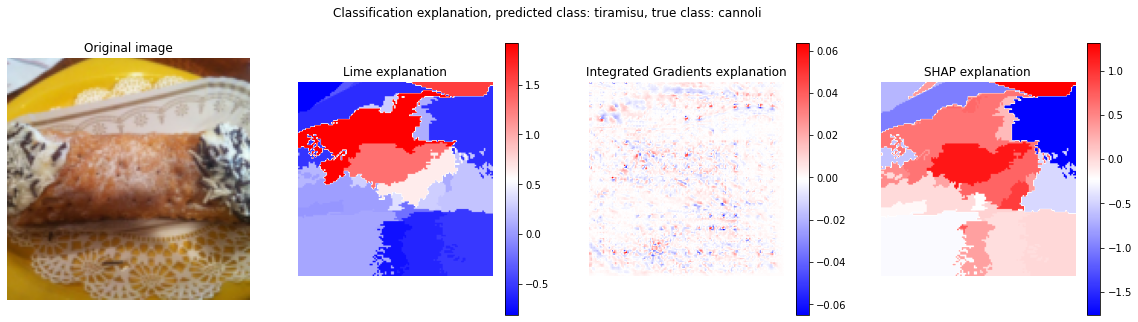

In [51]:
explain_image(model, single_test_loader, 148, dataset.classes)

ALgorytm IG w tym przypadku nie pokazał za dużo istotnych rzeczy.

Z drugiej strony, z Lime oraz SHAP można zauważyć, że na predykcję na tiramisu wpłynęło samo cannoli, ale także biały talerzyk oraz kawałek brązowego blatu w górnej części zdjęcia.

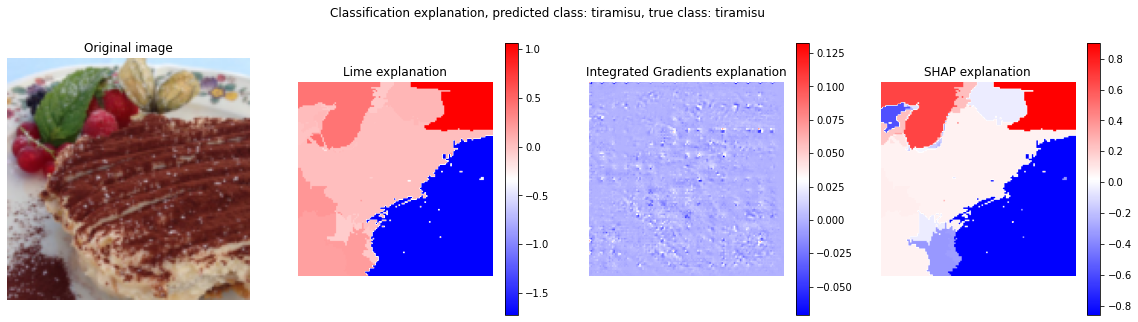

In [52]:
explain_image(model, single_test_loader, 0, dataset.classes)

W tym przypadku IG również nie za dużo nam pokazało. 

Natomiast, z Lime oraz SHAP wynika, że pozytywny wpływ na predykcję miał biały talerz w górnej części zdjęcia, a negatywny kakao w prawym dolnym rogu. Druga część tiramisu miała lekko dodatni lub neutralny wpływ na predykcję.

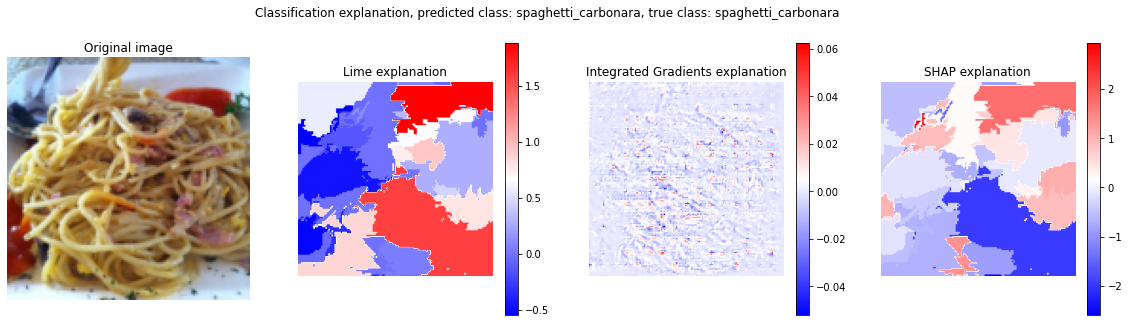

In [60]:
explain_image(model, single_test_loader, 63, dataset.classes)

Dla IG widać bardzo lekko zarys makaronu - jednak znów ta metoda nie dostarczyła dobrego wyjaśnienia. Widać tylko pojedyncze czerwone punkty w różnych miejscach.

Lime "zobaczył", że superpiksel w prawym dolnym rogu odpowiada za makaron, podczas gdy wg. SHAPa, ten superpiksel wpływał negatywnie.

Ponadto, znów widać duży pozytywny wpływ białego talerza w górnej części zdjęcia.

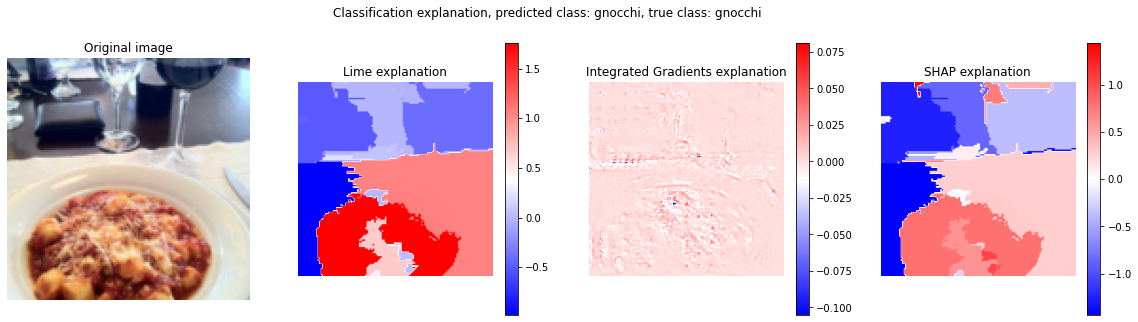

In [70]:
explain_image(model, single_test_loader, 43, dataset.classes)

ALgorytm IG wykrył brzegi talerza i stołu - są one lekko widoczne.

Lime oraz SHAP dobrze wykryły, że w talerzu znajdują się gnocchi, chociaż Lime dla wnętrza talerza miał mniejszy dodatki współczynnik niż dla superpikseli zawierających talerz.

Znowu widać, że stół/nakrycie mają dość wysoki wpółczynnik dla Lime/SHAP, jednakże inna część stołu ma negatywny.

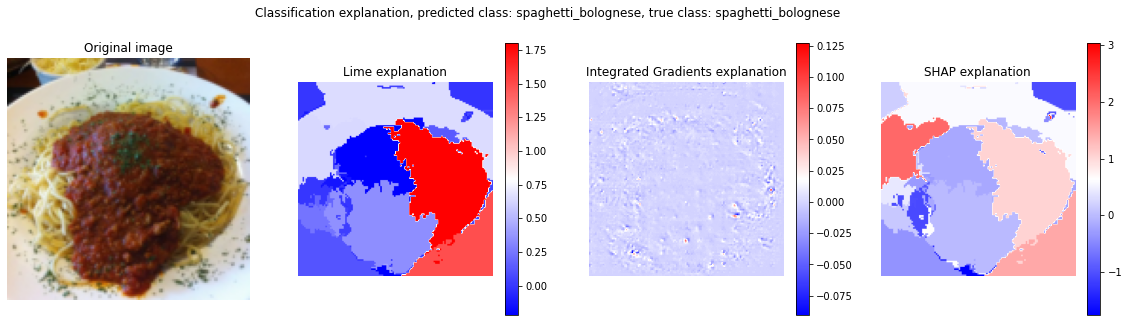

In [106]:
explain_image(model, single_test_loader, 21, dataset.classes)

Na wykresie IG widać tylko lekko obrys talerza.

Segmentacja zdjęcia pozwoliła wykryć talerz, jednak został on podzielony na trzy części. Według Lime/SHAP tylko połowa jego okazała się mieć pozytywny wpływ na model (w tym superpikselu mamy zarówno sos jak i makaron, a w innych jest raczej jeden element).

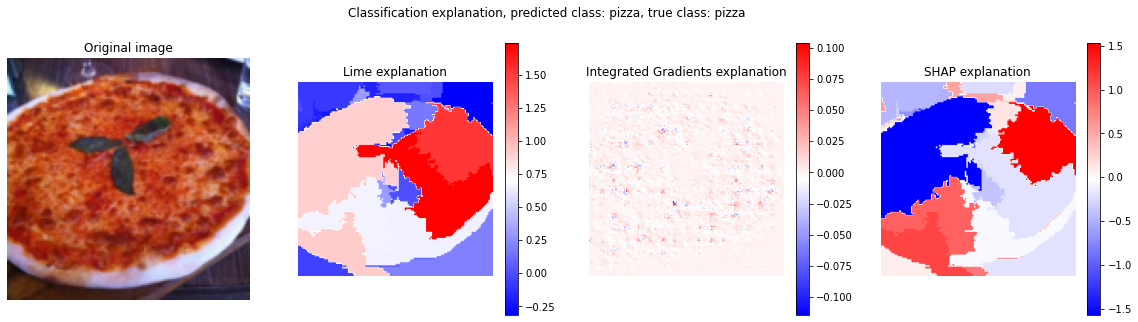

In [111]:
explain_image(model, single_test_loader, 17, dataset.classes)

W tym przypadku IG odkrył brzegi pizzy i jej mocniej przypieczone części.

Segmentacja znów podzieliła danie na trzy części. Lime przypisał dodatnie współczynniki praktycznie każdemu superpikselowi zawierającemu pizzę (nie licząc liścia bazylii. Dla SHAPa tylko część pizzy dała pozytywne współczynniki.

In [122]:
def explain_image_and_true_class(m, single_test_loader, idx, mapping):
    i = 0
    img = None
    for batch in single_test_loader:  
        if i == idx:
            img = batch[0][0]
            label = batch[1]
            break
        i = i + 1

    _, predicted = model(img.unsqueeze(0)).max(1)
    predicted = predicted.item()


    fig = plt.figure(figsize = (20, 10))
    plt.suptitle(f'Classification explanation, predicted class: {mapping[predicted]}, true class: {mapping[label.item()]}')

    plt.subplot(2, 4, 1)
    plt.axis("off")
    plt.title('Original image')
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(2, 4, 2)
    lime_explain(m, img, label.item())
    plt.title(f"Lime explanation for class {mapping[label.item()]}")

    plt.subplot(2, 4, 3)
    IG_explain(m, img, label.item())
    plt.title(f"Integrated Gradients explanation for class {mapping[label.item()]}")

    plt.subplot(2, 4, 4)
    SHAP_explain(m, img, label.item())
    plt.title(f"SHAP explanation for class {mapping[label.item()]}")

    #####################

    plt.subplot(2, 4, 6)
    lime_explain(m, img, predicted)
    plt.title(f"Lime explanation for class {mapping[predicted]}")

    plt.subplot(2, 4, 7)
    IG_explain(m, img, predicted)
    plt.title(f"Integrated Gradients explanation or class {mapping[predicted]}")

    plt.subplot(2, 4, 8)
    SHAP_explain(m, img, predicted)
    plt.title(f"SHAP explanation or class {mapping[predicted]}")

    plt.show()    

### Wyjaśnienie błędnie zaklasyfikowanych zdjęć

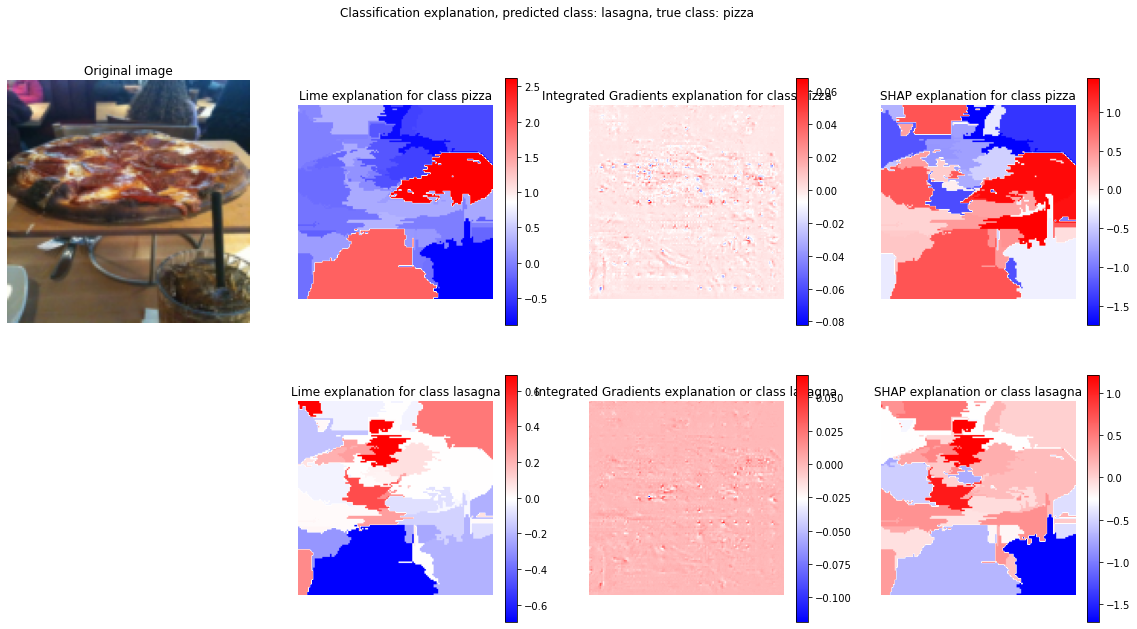

In [123]:
explain_image_and_true_class(model, single_test_loader, 103, dataset.classes)

IG również jak poprzednio pokazał tylko ledwo widoczne zarysy obiektów.

Według Lime były tylko dwa superpiksele świadczące na rzecz pizzy, z czego jeden to był stolik. Z drugiej strony, Lime dla klasy lasagne nie zaklasyfikował ujemnie żadnego elementu pizzy, ale zaznaczył pozytywnie tło w prawej górnej części zdjecia.

SHAP widział trochę więcej pozytywnych elementów dla pizzy (a praktycznie większość dla lasagne), jednak wciąż zaznaczył stolik pozytywnie, a dla lasagne stolik negatywnie. Podobnie, tło w prawym górnym rogu - dla pizzy jest negatywne, a dla lasagne dodatnie.

Uważam, że właśnie te dwa elementy zdjęcia mogły zmylić model. Zdjęcie jest nietypowe, pizza jest na zdjęciu pod nietypowym kątem i model mógł jej "nie dojrzeć". Ponadto, oba wyjaśnienia dla obu klas wskazują właśnie te superpiksele, a stolik faktycznie może kolorem przypominać pizzę.

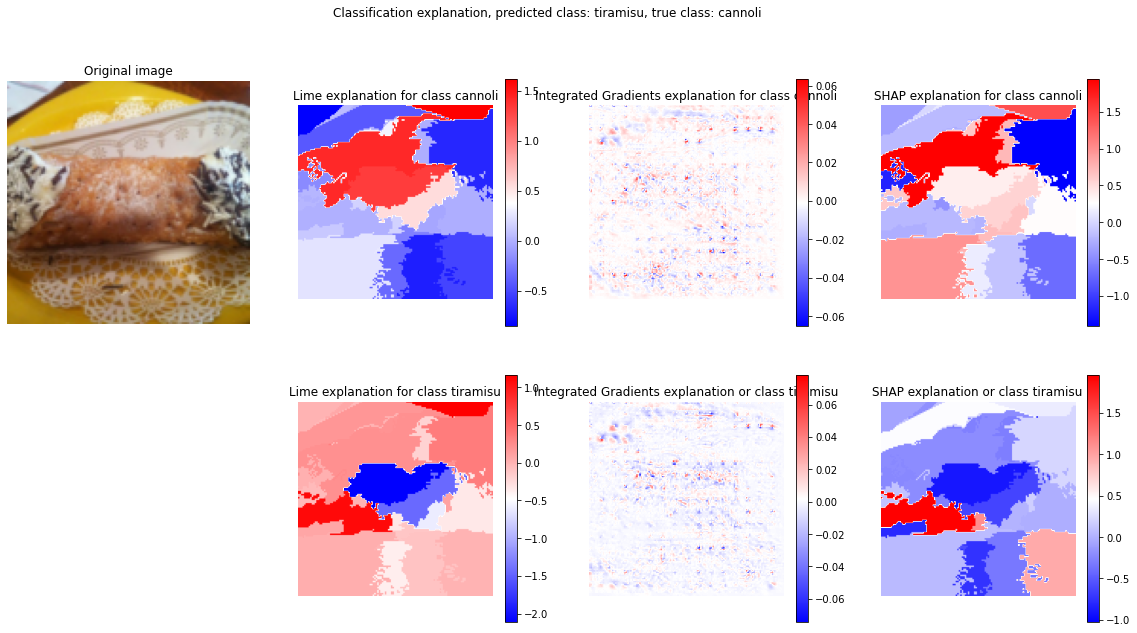

In [124]:
explain_image_and_true_class(model, single_test_loader, 148, dataset.classes)

IG znów wskazał raczej słabo widoczne zarysy obiektów.

Najważniejsze jest to, że głównym elementem poróżniającym klasy jest środek zdjęcia, czyli samo ciasto - pod żadnym względem nie przypomina ono tiramisu, a przypomina cannoli. 

Jednakże, według Lime i SHAP superpikselem, który miał największy wpływ był ten, który przedstawia cień oraz kawałki czekolady z lewej strony. Być może ten cień wygląda, jakby to było kakao.

Lime zaznaczył również kawałek brązowego stołu w górnej części zdjęcia - zapewne przypomina to znów kakao (SHAP jednak tego nie zaznaczył).